# Tarea calificada 1 INAR_2023


## Cat vs. Dog Image Classification

Este ejercicio consiste en desarrollar un modelo deep learning CNN (aunque eres libre de probar otras alternativas) para una dataset que contiene imágenes de perros y gatos (exclusivamente). 

Se debe entregar este notebook (como mínimo, se pueden entregar varios notebooks en un .zip) con los siguientes puntos:

1. Carga y pre-proceso de ficheros de datos. (**YA DESARROLLADO, SOLO DEBE SER EJECUTADO**)
2. Configura un (uno al menos, puedes presentar más) modelo CNN para la clasificación perro versus gato.
3. Realiza el entrenamiento y prueba el rendimiento del modelo con el conjunto de test que hemos recopilado en clase este año.

El dataset y la primera parte de este notebook están obtenidos, con infinitas gracias, de

https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part1.ipynb

Por tanto se debe mencionar la siguiente licencia:

#### Copyright 2018 Google LLC.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License.

You may obtain a copy of the License at

 https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and limitations under the License.


## 1. Carga y Pre-Proceso de Datos

Descarga por favor el .zip 

cats_and_dogs_filtered.zip

del Blackboard de la tarea en la misma ruta (carpeta) de este notebook y ejecuta los siguientes pasos.

(o si usas Google Colab lo tienes en la dirección anterior)

Mantengo la nota original del origen del dataset.


**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [3]:
import os
import zipfile

# Si existe el zip lo extrae
if os.path.exists('./dataset_tarea_1_2023.zip'):
    local_zip = './dataset_tarea_1_2023.zip'
    zip_ref = zipfile.ZipFile(local_zip, 'r')
    zip_ref.extractall('')
    zip_ref.close()

The contents of the .zip are extracted to the base directory `cats_and_dogs_filtered`, which contains `train` and `validation` subdirectories for the training and validation datasets (see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/validation/check-your-intuition) for a refresher on training, validation, and test sets), which in turn each contain `cats` and `dogs` subdirectories. 

NOTA: Además, en el mismo directorio donde se descomprime el cats_and_dogs_filtered descomprime el test.zip en un directorio test. 

Si todo está bien nombrado y "colgando" de la misma ruta, te saldrán los siguientes tamaños de conjuntos train     /validation / test (un poco más adelante)

- total training cat images: 1000
- total training dog images: 1000
- total validation cat images: 500
- total validation dog images: 500
- total test cat images: 155
- total test dog images: 158



In [4]:
base_dir = './dataset_tarea_1_2023'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Directory with our test cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')

# Directory with our test dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')

Now, let's see what the filenames look like in the `cats` and `dogs` `train` directories (file naming conventions are the same in the `validation` directory):

In [5]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.238.jpg', 'cat.385.jpg', 'cat.386.jpg', 'cat.145.jpg', 'cat.607.jpg', 'cat.938.jpg', 'cat.658.jpg', 'cat.271.jpg', 'cat.466.jpg', 'cat.423.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Let's find out the total number of cat and dog images in the `train` and `validation` directories:

In [6]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 461
total test dog images: 277


For both cats and dogs, we have 1,000 training images and 500 test images.

Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplot parameters:

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 cat and 8 dog pictures. You can rerun the cell to see a fresh batch each time:

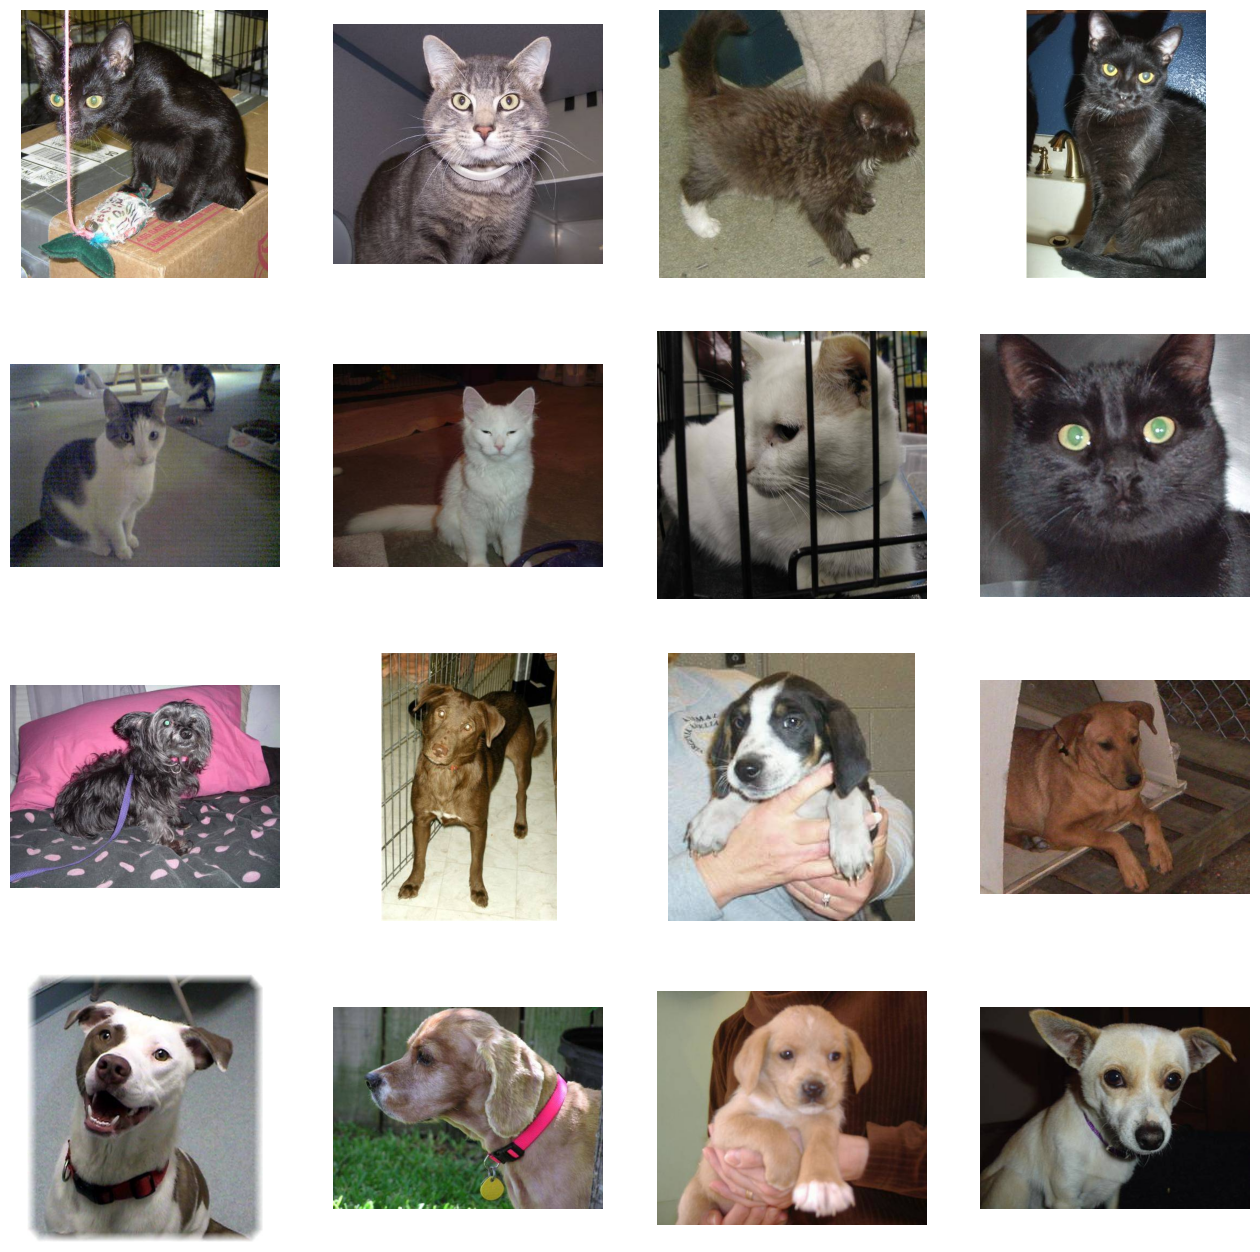

In [8]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()


### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of 20 images of size 150x150 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit_generator`, `evaluate_generator`, and `predict_generator`.

In [9]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

base_dir = './dataset_tarea_1_2023'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


# Flow training images in batches of 20 using train_datagen generator
train_generator = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False)


# Flow training images in batches of 20 using train_datagen generator
validation_generator = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False)

# Flow training images in batches of 20 using train_datagen generator
test_generator = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 738 files belonging to 2 classes.


# 2. Modelo CNN (con summary + compile)

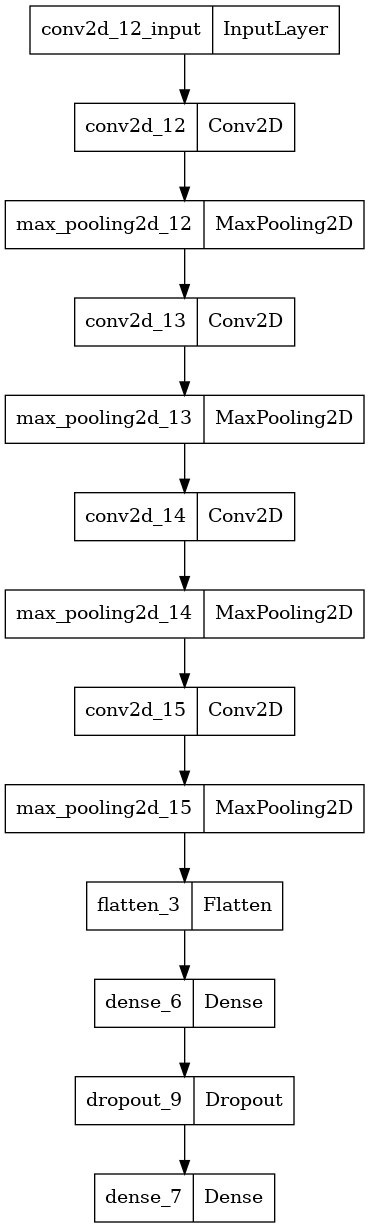

In [14]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.utils import plot_model
import os

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(2, 2))  
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

# Mostrar la gráfica de la red neuronal
PATH = os.getcwd() + '/model.png'
plot_model(model, to_file=PATH)


# 3. Entrenamiento del modelo (.fit) y rendimiento del modelo (accuracy) con conjunto test

Epoch 1/10


63/63 - 6s - loss: 26.5175 - accuracy: 0.4895 - val_loss: 0.6932 - val_accuracy: 0.4980 - 6s/epoch - 88ms/step
Epoch 2/10
63/63 - 5s - loss: 0.6938 - accuracy: 0.4950 - val_loss: 0.6931 - val_accuracy: 0.5050 - 5s/epoch - 76ms/step
Epoch 3/10
63/63 - 5s - loss: 0.6929 - accuracy: 0.5140 - val_loss: 0.6932 - val_accuracy: 0.5010 - 5s/epoch - 76ms/step
Epoch 4/10
63/63 - 5s - loss: 0.6948 - accuracy: 0.5280 - val_loss: 0.6944 - val_accuracy: 0.5030 - 5s/epoch - 76ms/step
Epoch 5/10
63/63 - 5s - loss: 0.6908 - accuracy: 0.5245 - val_loss: 0.6976 - val_accuracy: 0.5120 - 5s/epoch - 76ms/step
Epoch 6/10
63/63 - 5s - loss: 0.6856 - accuracy: 0.5460 - val_loss: 0.7005 - val_accuracy: 0.5240 - 5s/epoch - 75ms/step
Epoch 7/10
63/63 - 5s - loss: 0.6772 - accuracy: 0.5610 - val_loss: 0.7043 - val_accuracy: 0.5290 - 5s/epoch - 75ms/step
Epoch 8/10
63/63 - 5s - loss: 0.6653 - accuracy: 0.5670 - val_loss: 0.7165 - val_accuracy: 0.5140 - 5s/epoch - 75ms/step
Epoch 9/10
63/63 - 5s - loss: 0.6333 - acc

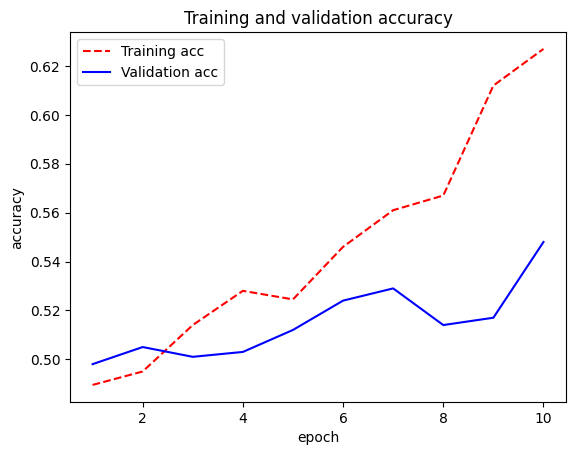

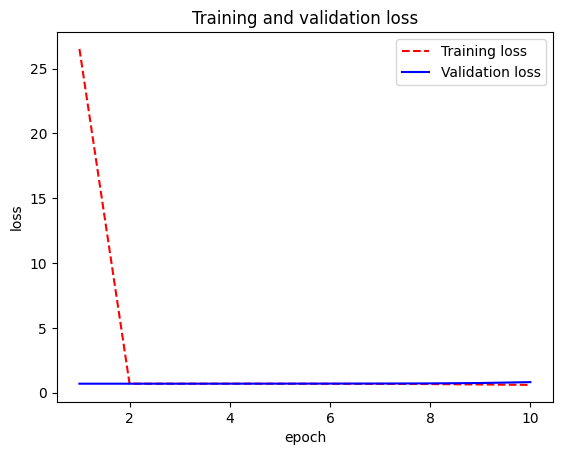

24/24 [==============================] - 7s 201ms/step - loss: 0.9400 - accuracy: 0.5014


In [13]:
epochs = 100

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    verbose=2,
)

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

# Dibujar las gráficas de precisión y pérdida

plt.plot(epochs, acc, 'r--', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r--', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend()
plt.show()

# Mostrar la precisión del modelo
test_loss, test_acc = model.evaluate(test_generator)

# 4. Trabajo adicional (Neural Transfer, Fine Tuning, visualización de capas intermedias ...)